In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

import statsmodels.api as sm

from sklearn.pipeline import make_pipeline

import pandas as pd
import numpy as np
import requests
import json
from urllib.parse import urlencode
warnings.filterwarnings("ignore")

In [7]:
endeks = pd.read_excel("C:/Users/Bora/Documents/GitHub/AI_Trade/excel/xu100saatlik.xlsx")
endeks['Saat'] = endeks['Saat'].astype(str)
endeks = endeks.set_index(pd.to_datetime(endeks["Tarih"], format="%d.%m.%Y"))
def temizle_ve_donustur(deger):
    deger = str(deger)  
    if ',' in deger:
        deger = deger.replace(',', '.')
    return float(deger)
endeks['Datetime'] = pd.to_datetime(endeks['Tarih'] + ' ' + endeks['Saat'], format='%d.%m.%Y %H:%M:%S')
endeks["Saat"]=endeks["Datetime"].dt.hour
endeks=endeks.set_index("Datetime")
endeks["Kapanış"] = endeks["Kapanış"].apply(temizle_ve_donustur)
endeks["Açılış"] = endeks["Açılış"].apply(temizle_ve_donustur)
endeks["Yüksek"] = endeks["Yüksek"].apply(temizle_ve_donustur)
endeks["Düşük"] = endeks["Düşük"].apply(temizle_ve_donustur)
endeks=endeks.drop(["Tarih","Ortalama","Lot"],axis=1)
endeks.columns=["Saat","Open","High","Low","Close","Volume"]
endeks["Pivot"]=(endeks["Close"].shift(1)+endeks["High"].shift(1)+endeks["Low"].shift(1))/3
endeks["R1"]=(2*endeks["Pivot"])-endeks["Low"].shift(1)
endeks["R2"]=(endeks["Pivot"])-endeks["Low"].shift(1)+endeks["High"].shift(1)
endeks["S2"]=(endeks["Pivot"])+endeks["Low"].shift(1)-endeks["High"].shift(1)
endeks["S1"]=(2*endeks["Pivot"])-endeks["High"].shift(1)

data=endeks.copy()
import pandas as pd
import ta
import numpy as np
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

# Hareketli Ortalama Kesişim
data['Golden_Cross'] = np.where((data['SMA_50'] > data['SMA_200']), 1, 0)

# RSI (Relative Strength Index)
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['RSI_Signal'] = np.where((data['RSI'].shift(1) < 30) & (data["RSI"]>30), 1, 0)  # Aşırı satım

# MACD
macd = ta.trend.MACD(data['Close'])
data['MACD'] = macd.macd()
data['MACD_Signal'] = macd.macd_signal()
data['MACD_Buy'] = np.where(data['MACD'] > data['MACD_Signal'], 1, 0)

# Bollinger Bantları
bollinger = ta.volatility.BollingerBands(data['Close'])
data['BB_High'] = bollinger.bollinger_hband()
data['BB_Low'] = bollinger.bollinger_lband()
data['BB_Breakout'] = np.where(data['Close'] > data['BB_High'], 1, 0)

# Hacim Değişimi
data['Volume_Change'] = data['Volume'].rolling(10).mean()
data['Volume_Spike'] = np.where(data['Volume'] > data["Volume_Change"], 1, 0)  # %200 artış

# ATR (Volatilite)
data['ATR'] = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close']).average_true_range()

# Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(data['High'], data['Low'], data['Close'])
data['Stoch'] = stoch.stoch()
data['Stoch_Signal'] = stoch.stoch_signal()
data['Stoch_Buy'] = np.where(data['Stoch'] < 20, 1, 0)  # Aşırı satım


# Donchian Kanalları
donchian_period = 20
data['Donchian_High'] = data['High'].rolling(window=donchian_period).max()
data['Donchian_Low'] = data['Low'].rolling(window=donchian_period).min()
data['Donchian_Breakout'] = np.where(data['Close'] > data['Donchian_High'], 1, 
                                     np.where(data['Close'] < data['Donchian_Low'], -1, 0))

# ADX (Average Directional Index)
adx = ta.trend.ADXIndicator(data['High'], data['Low'], data['Close'], window=14)
data['ADX'] = adx.adx()
data['ADX_Strong_Trend'] = np.where(data['ADX'] > 25, 1, 0)

# Parabolic SAR
parabolic_sar = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close'])
data['Parabolic_SAR'] = parabolic_sar.psar()
data['Parabolic_SAR_Buy'] = np.where(data['Close'] > data['Parabolic_SAR'], 1, 0)

# Keltner Kanalları
keltner = ta.volatility.KeltnerChannel(data['High'], data['Low'], data['Close'])
data['Keltner_High'] = keltner.keltner_channel_hband()
data['Keltner_Low'] = keltner.keltner_channel_lband()
data['Keltner_Breakout'] = np.where(data['Close'] > data['Keltner_High'], 1, 
                                     np.where(data['Close'] < data['Keltner_Low'], -1, 0))

# Williams %R
williams_r = ta.momentum.WilliamsRIndicator(data['High'], data['Low'], data['Close'], lbp=14)
data['Williams_%R'] = williams_r.williams_r()
data['Williams_Buy'] = np.where(data['Williams_%R'] < -80, 1, 0)

# Ichimoku Bulutu
ichimoku = ta.trend.IchimokuIndicator(data['High'], data['Low'], window1=9, window2=26, window3=52)
data['Ichimoku_Base'] = ichimoku.ichimoku_base_line()
data['Ichimoku_Conversion'] = ichimoku.ichimoku_conversion_line()
data['Ichimoku_Buy'] = np.where(data['Close'] > ichimoku.ichimoku_base_line(), 1, 0)

# Fibonacci Retracement (Özel seviye hesaplaması)
recent_high = data['High'].rolling(window=20).max()
recent_low = data['Low'].rolling(window=20).min()
data['Fib_38.2'] = recent_low + 0.382 * (recent_high - recent_low)
data['Fib_61.8'] = recent_low + 0.618 * (recent_high - recent_low)
data['Fib_Buy'] = np.where(data['Close'] > data['Fib_61.8'], 1, 0)

# VWAP (Hacim Ağırlıklı Ortalama Fiyat)
data['VWAP'] = (data['Close'] * data['Volume']).cumsum() / data['Volume'].cumsum()
data['VWAP_Buy'] = np.where(data['Close'] > data['VWAP'], 1, 0)





# Heiken Ashi Mumları
data['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4
data['HA_Open'] = (data['Open'].shift(1) + data['Close'].shift(1)) / 2
data['HA_High'] = data[['High', 'HA_Open', 'HA_Close']].max(axis=1)
data['HA_Low'] = data[['Low', 'HA_Open', 'HA_Close']].min(axis=1)
data['HA_Trend'] = np.where(data['HA_Close'] > data['HA_Open'], 1, 0)  # Uptrend = 1, Downtrend = 0

# Volume Oscillator
short_vol = data['Volume'].rolling(window=5).mean()
long_vol = data['Volume'].rolling(window=20).mean()
data['Volume_Oscillator'] = (short_vol - long_vol) / long_vol
data['Volume_Oscillator_Buy'] = np.where(data['Volume_Oscillator'] > 0, 1, 0)

# Crossover RSI
rsi_ma = data['RSI'].rolling(window=5).mean()
data['RSI_Crossover_Buy'] = np.where(data['RSI'] > rsi_ma, 1, 0)

# EMA Crossover on RSI
data['RSI_EMA'] = data['RSI'].ewm(span=5).mean()
data['RSI_EMA_Crossover'] = np.where(data['RSI'] > data['RSI_EMA'], 1, 0)

# Price Action Patterns (Double Bottom / Double Top)
data['Double_Bottom'] = np.where(
    (data['Close'].shift(2) < data['Close'].shift(1)) &
    (data['Close'] > data['Close'].shift(1)) &
    (data['Close'] > data['Close'].shift(2)),
    1, 0
)
data['Double_Top'] = np.where(
    (data['Close'].shift(2) > data['Close'].shift(1)) &
    (data['Close'] < data['Close'].shift(1)) &
    (data['Close'] < data['Close'].shift(2)),
    1, 0
)

# Volume Price Trend (VPT)
data['VPT'] = (data['Volume'] * (data['Close'] - data['Close'].shift(1)) / data['Close'].shift(1)).cumsum()

# Fractal Indicator
data['Fractal_High'] = np.where((data['High'] > data['High'].shift(1)) & 
                                (data['High'] > data['High'].shift(-1)), 1, 0)
data['Fractal_Low'] = np.where((data['Low'] < data['Low'].shift(1)) & 
                               (data['Low'] < data['Low'].shift(-1)), 1, 0)

# Chaikin Oscillator
ad_line = ta.volume.AccDistIndexIndicator(data['High'], data['Low'], data['Close'], data['Volume']).acc_dist_index()
data['Chaikin_Oscillator'] = ad_line.ewm(span=3).mean() - ad_line.ewm(span=10).mean()

# Elder Ray Index
data['Bull_Power'] = data['High'] - data['Close'].ewm(span=13).mean()
data['Bear_Power'] = data['Low'] - data['Close'].ewm(span=13).mean()
data['Elder_Buy'] = np.where(data['Bull_Power'] > 0, 1, 0)

# Diverjans (RSI ve Fiyat Arasında)
data['RSI_Divergence'] = np.where(
    (data['RSI'].diff() > 0) & (data['Close'].diff() < 0), 1, 
    np.where((data['RSI'].diff() < 0) & (data['Close'].diff() > 0), -1, 0)
)



# Trix (Triple Exponential Average)
trix = ta.trend.TRIXIndicator(data['Close'], window=15)
data['Trix'] = trix.trix()
data['Trix_Buy'] = np.where(data['Trix'] > 0, 1, 0)

# Hull Moving Average (HMA)
period = 14
half_period = int(period / 2)
sqrt_period = int(np.sqrt(period))
data['WMA1'] = data['Close'].rolling(window=half_period).mean()
data['WMA2'] = data['Close'].rolling(window=period).mean()
data['HMA'] = 2 * data['WMA1'] - data['WMA2']
data['HMA'] = data['HMA'].rolling(window=sqrt_period).mean()
data['HMA_Buy'] = np.where(data['Close'] > data['HMA'], 1, 0)

# Money Flow Index (MFI)
mfi = ta.volume.MFIIndicator(data['High'], data['Low'], data['Close'], data['Volume'], window=14)
data['MFI'] = mfi.money_flow_index()
data['MFI_Buy'] = np.where(data['MFI'] < 20, 1, 0)

# Commodity Channel Index (CCI)
cci = ta.trend.CCIIndicator(data['High'], data['Low'], data['Close'], window=20)
data['CCI'] = cci.cci()
data['CCI_Buy'] = np.where(data['CCI'] > 100, 1, 0)

# Supertrend
atr = ta.volatility.AverageTrueRange(data['High'], data['Low'], data['Close'], window=10).average_true_range()
data['Supertrend'] = data['Close'] - (2 * atr)
data['Supertrend_Buy'] = np.where(data['Close'] > data['Supertrend'], 1, 0)

# Rate of Change (ROC)
roc = ta.momentum.ROCIndicator(data['Close'], window=12)
data['ROC'] = roc.roc()
data['ROC_Buy'] = np.where(data['ROC'] > 0, 1, 0)

# Son X Günlük En Yüksek/Alçak Testi
data['High_X_Days'] = data['High'].rolling(window=20).max()
data['Low_X_Days'] = data['Low'].rolling(window=20).min()
data['Range_Breakout'] = np.where((data['Close'] > data['High_X_Days']) | (data['Close'] < data['Low_X_Days']), 1, 0)

# Vortex Indicator
vortex = ta.trend.VortexIndicator(data['High'], data['Low'], data['Close'], window=14)
data['VI_Positive'] = vortex.vortex_indicator_pos()
data['VI_Negative'] = vortex.vortex_indicator_neg()
data['Vortex_Buy'] = np.where(data['VI_Positive'] > data['VI_Negative'], 1, 0)

# Günlük Gap Analizi
data['Gap'] = data['Open'] - data['Close'].shift(1)
data['Gap_Buy'] = np.where(data['Gap'] > data['Close'] * 0.02, 1, 0)  # %2 yukarı gap


# Moving Average Ribbon
data['MA_Short'] = data['Close'].rolling(window=10).mean()
data['MA_Medium'] = data['Close'].rolling(window=20).mean()
data['MA_Long'] = data['Close'].rolling(window=50).mean()
data['MA_Ribbon_Buy'] = np.where((data['MA_Short'] > data['MA_Medium']) & (data['MA_Medium'] > data['MA_Long']), 1, 0)

# Kumo Twist (Ichimoku)
data['Kumo_Twist'] = np.where(data['Ichimoku_Base'] > data['Ichimoku_Conversion'], 1, 0)

# RSI + MACD Combo
data['RSI_MACD_Combo'] = np.where((data['RSI_Signal'] == 1) & (data['MACD_Buy'] == 1), 1, 0)

# Volatility Squeeze
data['Volatility_Squeeze'] = np.where((data['BB_High'] - data['BB_Low']) < (data['Keltner_High'] - data['Keltner_Low']), 1, 0)

# Volume Weighted RSI (VW-RSI)
data['VWRSI'] = ta.momentum.RSIIndicator((data['Close'] * data['Volume']).rolling(window=14).mean(), window=14).rsi()
data['VWRSI_Buy'] = np.where(data['VWRSI'] < 30, 1, 0)

window = 10
high_low_mean = (data['High'] + data['Low']) / 2
data['Fisher_Normalized'] = 2 * ((data['Close'] - data['Low'].rolling(window).min()) / 
                                 (data['High'].rolling(window).max() - data['Low'].rolling(window).min())) - 1
data['Fisher_Transform'] = 0.5 * np.log((1 + data['Fisher_Normalized']) / (1 - data['Fisher_Normalized']))

# Fisher Transform Alım Sinyali
data['Fisher_Buy'] = np.where(data['Fisher_Transform'] > 0, 1, 0)

# True Strength Index (TSI)
tsi = ta.momentum.TSIIndicator(data['Close'], window_slow=25, window_fast=13)
data['TSI'] = tsi.tsi()
data['TSI_Buy'] = np.where(data['TSI'] > 0, 1, 0)

# ADX + DI Combo
data['ADX_DI_Combo'] = np.where((data['ADX_Strong_Trend'] == 1) & (adx.adx_pos() > adx.adx_neg()), 1, 0)

# Ulcer Index
max_close = data['Close'].rolling(window=14).max()
data['Ulcer_Index'] = np.sqrt(((data['Close'] - max_close) / max_close).pow(2).mean())
data['Ulcer_Buy'] = np.where(data['Ulcer_Index'] < 0.02, 1, 0)

# Percentage Price Oscillator (PPO)
ppo = ta.momentum.PercentagePriceOscillator(data['Close'], window_slow=26, window_fast=12)
data['PPO'] = ppo.ppo()
data['PPO_Buy'] = np.where(data['PPO'] > 0, 1, 0)

# Pivot Reversal Strategy
data['Pivot_Reversal'] = np.where((data['Close'] > data['High'].shift(1)) & (data['Close'] > data['Low'].shift(1)), 1, 0)

# Schaff Trend Cycle (STC)
data['STC'] = ta.trend.STCIndicator(data['Close'], window_slow=50, window_fast=23).stc()
data['STC_Buy'] = np.where(data['STC'] > 25, 1, 0)




















data["Yön"]=np.where((data["Close"].pct_change()>0),1,0)
data["Yön"]=data["Yön"].shift(-1)
data=data.loc["2012":]
data=data.dropna()
data

,Saat,Open,High,Low,Close,Volume,Pivot,R1,R2,S2,...,TSI_Buy,ADX_DI_Combo,Ulcer_Index,Ulcer_Buy,PPO,PPO_Buy,Pivot_Reversal,STC,STC_Buy,Yön
Datetime,,,,,,,,,,,,,,,,,,,,,
2012-01-02 09:00:00,9,513.15,513.62,510.29,511.92,33143120,513.763333,517.396667,522.123333,505.403333,...,0,0,0.053789,0,-77.371701,0,0,100.000000,1,1.0
2012-01-02 10:00:00,10,511.83,515.01,511.44,512.70,176168900,511.943333,513.596667,515.273333,508.613333,...,0,0,0.053789,0,-76.024996,0,0,100.000000,1,1.0
2012-01-02 11:00:00,11,512.89,515.01,512.48,513.41,81592330,513.050000,514.660000,516.620000,509.480000,...,0,0,0.053789,0,-74.615389,0,0,100.000000,1,1.0
2012-01-02 12:00:00,12,513.42,514.11,512.25,513.46,25864250,513.633333,514.786667,516.163333,511.103333,...,0,0,0.053789,0,-73.148692,0,0,100.000000,1,1.0
2012-01-02 14:00:00,14,513.95,516.59,513.63,515.91,114867400,513.273333,514.296667,515.133333,511.413333,...,0,0,0.053789,0,-71.608844,0,1,100.000000,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-25 16:00:00,16,9718.76,9720.33,9675.73,9696.79,15632180000,9687.413333,9749.266667,9780.963333,9593.863333,...,1,1,0.053789,0,1.076277,1,0,99.999988,1,0.0
2024-11-25 17:00:00,17,9697.54,9712.20,9650.27,9665.16,16432070000,9697.616667,9719.503333,9742.216667,9653.016667,...,1,1,0.053789,0,1.046336,1,0,99.999994,1,0.0
2024-11-25 18:00:00,18,9666.46,9666.46,9659.96,9659.96,11040230000,9675.876667,9701.483333,9737.806667,9613.946667,...,1,1,0.053789,0,1.006522,1,0,99.999997,1,0.0


In [8]:
cols=["Close","Golden_Cross","RSI_Signal","BB_Breakout","Volume_Spike","Stoch_Buy","Donchian_Breakout","ADX_Strong_Trend","Parabolic_SAR_Buy",
                        "Keltner_Breakout","Williams_Buy","Ichimoku_Buy","Fib_Buy","VWAP_Buy","HA_Trend","Volume_Oscillator_Buy","RSI_Crossover_Buy","RSI_EMA_Crossover","Double_Bottom","Double_Top","Elder_Buy",
                        "RSI_Divergence","Trix_Buy","HMA_Buy","MFI_Buy","CCI_Buy","Supertrend_Buy","ROC_Buy","Vortex_Buy","Gap_Buy","MA_Ribbon_Buy","RSI_MACD_Combo","Volatility_Squeeze","VWRSI_Buy",
                        "Fisher_Buy","TSI_Buy","ADX_DI_Combo","Ulcer_Buy","PPO_Buy","Pivot_Reversal","STC_Buy","Yön"]

In [4]:
import keras
from keras.layers import Dense,LSTM,Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import tensorflow as tf
from catboost import CatBoostClassifier
import optuna
def objective(trial):

    scaler=MinMaxScaler()
    scaler2=MinMaxScaler()
    datam=data[cols]
    X=datam.drop(["Yön","Close"],axis=1)
    y=datam["Yön"]
    X_scaled=scaler.fit_transform(X)
    y_scaled=scaler2.fit_transform(np.array(y).reshape(-1,1))


    X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
    X_scaled.index=X.index
    y_scaled=pd.DataFrame(y_scaled)
    y_scaled.index=y.index
    y_scaled.columns=["Kapanış"]

    X_train,X_test=X_scaled.loc[:"2020"],X_scaled.loc["2021":]
    y_train,y_test=y_scaled.loc[:"2020"],y_scaled.loc["2021":]

    X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,shuffle=False)

    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 3, 15),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.1, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 1e-3, 10),
        'random_seed': 42,
        'loss_function': 'CrossEntropy',
        'eval_metric': 'CrossEntropy',
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
    
    y_pred = model.predict(X_test)

    tahminler = pd.DataFrame(scaler2.inverse_transform(y_test).reshape(1,-1)[0])
    tahminler.columns = ["BIST100"]
    tahminler["Tahmin"] = scaler2.inverse_transform(y_pred.reshape(-1,1))
    
    tahminler.index=X_test.index
    tahminler["Fiyat"]=datam["Close"].loc[tahminler.index]

    tahminler=tahminler.shift(1)
    tahminler["Saat"]=endeks["Saat"].loc[tahminler.index]
    from sklearn.metrics import accuracy_score



    tahminler=tahminler.dropna()

    buy_points=[]
    sell_points=[]
    yön=""
    bakiye=[1000000]
    for i in range(len(tahminler)):
            if (tahminler["Tahmin"].iloc[i]==1) & (yön=="") & (tahminler["Saat"].iloc[i]!=18)& (tahminler["Saat"].iloc[i]!=9):
                alışfiyat=tahminler["Fiyat"].iloc[i]
                yön="A"
                lot=bakiye[-1]//alışfiyat
                komisyon=(lot*alışfiyat*0.0004)+(0.000025*lot*alışfiyat*0.0004)+(lot*alışfiyat*0.0004*0.05)
                bakiye.append(bakiye[-1]-komisyon)
                buy_points.append(tahminler.index[i])
            elif (tahminler["Tahmin"].iloc[i]==0) & (yön=="A")& (tahminler["Saat"].iloc[i]!=18)& (tahminler["Saat"].iloc[i]!=9):
                satışfiyat=tahminler["Fiyat"].iloc[i]
                komisyon=(lot*satışfiyat*0.0004)+(0.000025*lot*satışfiyat*0.0004)+(lot*satışfiyat*0.0004*0.05)
                kar=(satışfiyat-alışfiyat)*lot
                kar=kar-komisyon
                bakiye.append(bakiye[-1]+kar)
                yön=""
                sell_points.append(tahminler.index[i])
            else:
                bakiye.append(bakiye[-1])

    getiri=bakiye[-1]/1000000
    try:
            return getiri
    except:
        return 0

"""study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)"""




"study = optuna.create_study(direction='maximize')\nstudy.optimize(objective, n_trials=500)"

In [40]:
study.best_params

{'iterations': 622,
 'learning_rate': 0.021471580250204025,
 'depth': 4,
 'l2_leaf_reg': 0.01053403705858687,
 'bagging_temperature': 0.5328825753378976,
 'random_strength': 5.6046203341486525}

In [9]:
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
datam=data[cols]
X=datam.drop(["Yön","Close"],axis=1)
y=datam["Yön"]
X_scaled=scaler.fit_transform(X)
y_scaled=scaler2.fit_transform(np.array(y).reshape(-1,1))


X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.index=X.index
y_scaled=pd.DataFrame(y_scaled)
y_scaled.index=y.index
y_scaled.columns=["Kapanış"]

X_train,X_test=X_scaled.loc[:"2020"],X_scaled.loc["2021":]
y_train,y_test=y_scaled.loc[:"2020"],y_scaled.loc["2021":]

X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,shuffle=False)
params={'iterations': 622,
 'learning_rate': 0.021471580250204025,
 'depth': 4,
 'l2_leaf_reg': 0.01053403705858687,
 'bagging_temperature': 0.5328825753378976,
 'random_strength': 5.6046203341486525}

model = CatBoostClassifier(**params)
model.load_model("endeks.bin")


for ort in np.arange(18,19,1):
    for threshold in np.arange(0.5,0.505,0.01):
        scaler=MinMaxScaler()
        scaler2=MinMaxScaler()
        datam=data[cols]
        X=datam.drop(["Yön","Close"],axis=1)
        y=datam["Yön"]
        X_scaled=scaler.fit_transform(X)
        y_scaled=scaler2.fit_transform(np.array(y).reshape(-1,1))


        X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
        X_scaled.index=X.index
        y_scaled=pd.DataFrame(y_scaled)
        y_scaled.index=y.index
        y_scaled.columns=["Kapanış"]

        X_train,X_test=X_scaled.loc[:"2020"],X_scaled.loc["2021":]
        y_train,y_test=y_scaled.loc[:"2020"],y_scaled.loc["2021":]

        X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,random_state=42,shuffle=False)

        y_pred = model.predict_proba(X_test)[:,1]

        tahminler = pd.DataFrame(scaler2.inverse_transform(y_test).reshape(1,-1)[0])
        tahminler.columns = ["BIST100"]
        tahminler["Tahmin"] = scaler2.inverse_transform(y_pred.reshape(-1,1))

        tahminler.index=X_test.index
        tahminler["Fiyat"]=datam["Close"].loc[tahminler.index]

        tahminler=tahminler.shift(1)
        tahminler["Saat"]=endeks["Saat"].loc[tahminler.index]
        from sklearn.metrics import accuracy_score
        


        
        tahminler["Tahmin"]=tahminler["Tahmin"].ewm(span=ort,adjust=False).mean()
        tahminler=tahminler.dropna()
        buy_points=[]
        sell_points=[]
        yön=""
        bakiye=[1000000]
        for i in range(len(tahminler)):
    # Eğer pozisyon açılıyorsa
            if (tahminler["Tahmin"].iloc[i] >= threshold) and (yön == "") and (tahminler["Saat"].iloc[i] != 18):
                alışfiyat = tahminler["Fiyat"].iloc[i]*1.0005
                yön = "A"
                lot = bakiye[-1] // alışfiyat
                komisyon = (lot * alışfiyat * 0.0004) + (0.000025 * lot * alışfiyat * 0.0004) + (lot * alışfiyat * 0.0004 * 0.05)
                pozisyon_bakiyesi = bakiye[-1] - komisyon  # Pozisyon açılırken bakiye
                bakiye.append(pozisyon_bakiyesi)
                buy_points.append(tahminler.index[i])
            
            # Eğer pozisyon kapanıyorsa
            elif (tahminler["Tahmin"].iloc[i] < threshold) and (yön == "A"):
                satışfiyat = tahminler["Fiyat"].iloc[i]*0.9995
                komisyon = (lot * satışfiyat * 0.0004) + (0.000025 * lot * satışfiyat * 0.0004) + (lot * satışfiyat * 0.0004 * 0.05)
                kar = (satışfiyat - alışfiyat) * lot
                kar = kar - komisyon
                bakiye.append(pozisyon_bakiyesi + kar)  # Karı pozisyon açıldığındaki bakiyeye ekle
                yön = ""
                sell_points.append(tahminler.index[i])
            
            # Eğer pozisyon açıkken kar/zarar güncelleniyorsa
            elif yön == "A":
                anlık_fiyat = tahminler["Fiyat"].iloc[i]*0.9995
                anlık_kar = (anlık_fiyat - alışfiyat) * lot  # Anlık kar hesaplama
                bakiye.append(pozisyon_bakiyesi + anlık_kar)  # Karı pozisyon açıldığındaki bakiyeye ekle

            # Pozisyon yoksa bakiye aynı kalır
            else:
                bakiye.append(bakiye[-1])
        getiri=bakiye[-1]/1000000
        bakiye=pd.DataFrame(bakiye[1:])
        bakiye.index=tahminler.index
        returns=bakiye.pct_change()
        import quantstats as qs
        sharpe=qs.stats.sharpe(returns=returns)[0]
        print(f"Getiri:{getiri} Threshold:{threshold} EMA:{ort}")


   

Getiri:6.994184047067757 Threshold:0.5 EMA:18


In [10]:
tahminler.loc["2024-11-20":]

,BIST100,Tahmin,Fiyat,Saat
Datetime,,,,
2024-11-20 09:00:00,1.0,0.502213,9232.90,9
2024-11-20 10:00:00,1.0,0.500832,9272.75,10
2024-11-20 11:00:00,0.0,0.500482,9282.51,11
2024-11-20 12:00:00,0.0,0.501588,9272.35,12
2024-11-20 13:00:00,0.0,0.501879,9248.25,13
2024-11-20 14:00:00,1.0,0.502139,9241.77,14
2024-11-20 15:00:00,1.0,0.502450,9247.20,15
2024-11-20 16:00:00,0.0,0.502221,9248.96,16
2024-11-20 17:00:00,0.0,0.500796,9210.30,17


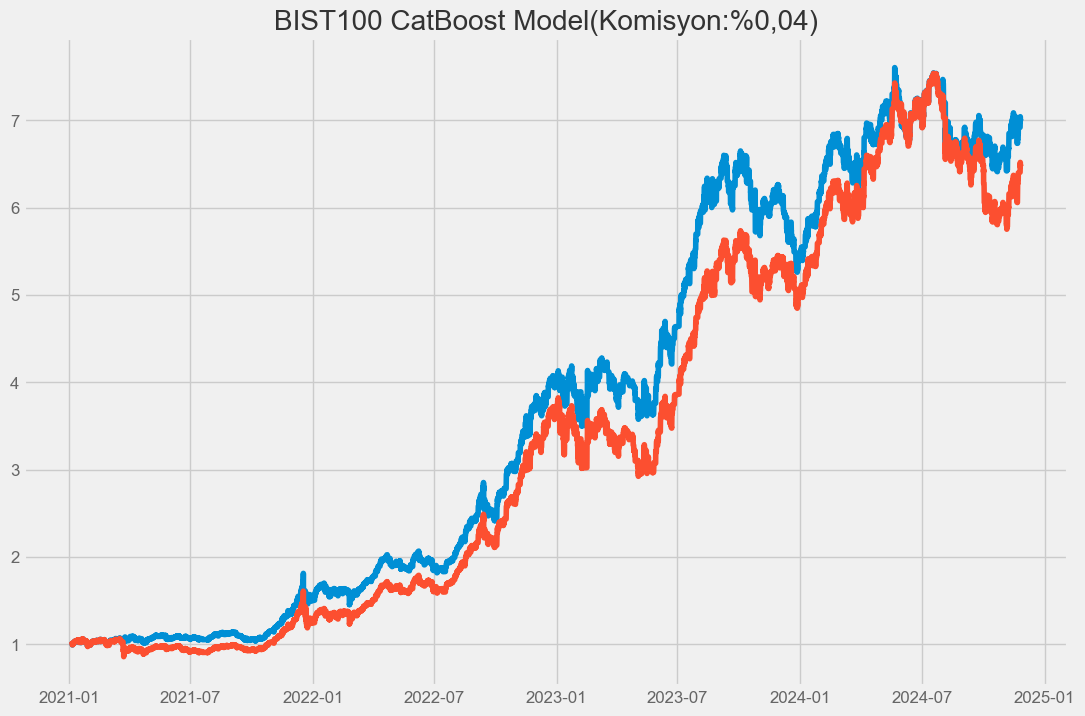

In [11]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(12,8))
plt.title("BIST100 CatBoost Model(Komisyon:%0,04)")


plt.plot(np.cumprod(bakiye.pct_change()+1))
plt.plot(np.cumprod(tahminler["Fiyat"].pct_change()+1))
